In [1]:
import pandas as pd
import numpy as np
import jieba, jieba.analyse
import matplotlib.pyplot as plt
import seaborn as sns

---
### Re-correct news sources and tokenize news content

In [2]:
df = pd.read_csv("data/news_modified.csv")
del df["Unnamed: 0"]
df.head()

,author,datetime,upvotes,downvotes,forwards,source,headline,original_link
0,Mordecai (莫迪凱),Mon Jan 23 13:45:31 2017,37,0,9,goo.gl,[新聞] 安徽老人組團攔花車 躺地耍賴逼付「喜錢,https://goo.gl/LccFQR
1,c8c8c8c8c8c8 (哈哈哈哈哈哈哈哈哈哈哈),Mon Jan 23 13:45:49 2017,21,0,11,tinyurl.com,[新聞] 慎入! 胸腹中箭險傷心臟 男子奇蹟生還,http://tinyurl.com/zt52dyj
2,fun5566 (台大板高中數學考古題神),Mon Jan 23 13:57:33 2017,32,4,14,NaN,[新聞] 持刀威脅男子舔下體、性交 美17歲少女긱,NaN
3,cisbpmtw (cisbpmtw),Mon Jan 23 14:01:38 2017,9,7,6,tinyurl.com,[新聞] 被狗追成精 他說這裡的狗比聯結車可怕,http://tinyurl.com/z9y57on
4,Kyo824 (Kyo),Mon Jan 23 14:02:52 2017,5,8,10,goo.gl,[新聞] 基因好強大！大S首次公開兒子正面照,https://goo.gl/SYGpVF


In [4]:
def tokenize(s):
    if pd.isnull(s) or not "[新聞]" in s:
        return ""
    else:
        return " ".join(jieba.cut(s.split("[新聞]")[1])).strip()

df["tokens"] = df["headline"].apply(tokenize)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/n0/1wf1ts910pjdlzbtp2q3dp8m0000gn/T/jieba.cache
Loading model cost 1.032 seconds.
Prefix dict has been built succesfully.


In [5]:
df.loc[df["source"].str.contains("epoch|大紀", na=False),"source"] = "epochtimes"
df.loc[df["source"].str.contains("imgur", na=False),"source"] = "imgur"
df.loc[df["source"].str.contains("youtu", na=False),"source"] = "youtube"
df.loc[df["source"].str.contains("cna|中央", na=False),"source"] = "cna"
df.loc[df["source"].str.contains("hinet", na=False),"source"] = "hinet"
df.loc[df["source"].str.contains("pts|公視", na=False),"source"] = "pts"
df.loc[df["source"].str.contains("peoplenews", na=False),"source"] = "peoplenews"
df.loc[df["source"].str.contains("ithome", na=False),"source"] = "ithome"
df.loc[df["source"].str.contains("中國時報", na=False),"source"] = "china times"
df.loc[df["source"].str.contains("cdnews", na=False),"source"] = "cdnews"
df.loc[df["source"].str.contains("rti", na=False),"source"] = "rti"
df.loc[df["source"].str.contains("ctee", na=False),"source"] = "ctee"
df.loc[df["source"].str.contains("nextmag", na=False),"source"] = "nextmag"
df.loc[df["source"].str.contains("科技新報", na=False),"source"] = "technews"
df.loc[df["source"].str.contains("3立|三立|setn", na=False),"source"] = "setn"
df.loc[df["source"].str.contains("lens|關鍵", na=False),"source"] = "thenewslens"
df.loc[df["source"].str.contains("initium|端傳", na=False),"source"] = "the initium"
df.loc[df["source"].str.contains("udn|經濟日報", na=False),"source"] = "udn"

In [6]:
df["datetime"] = df["datetime"].apply(lambda x: pd.to_datetime(x, errors='ignore')).astype(pd.Timestamp)
df["upvotes"] = pd.to_numeric(df["upvotes"], errors='coerce')

In [7]:
df["source"].value_counts().index[:15]

Index(['liberty times', 'apple', 'goo.gl', 'udn', 'ettoday', 'china times',
       'setn', 'imgur', 'epochtimes', 'tinyurl.com', 'cna', 'tvbs',
       'buzzorange', 'now news', 'storm media'],
      dtype='object')

---
### Plot top 15 news sources

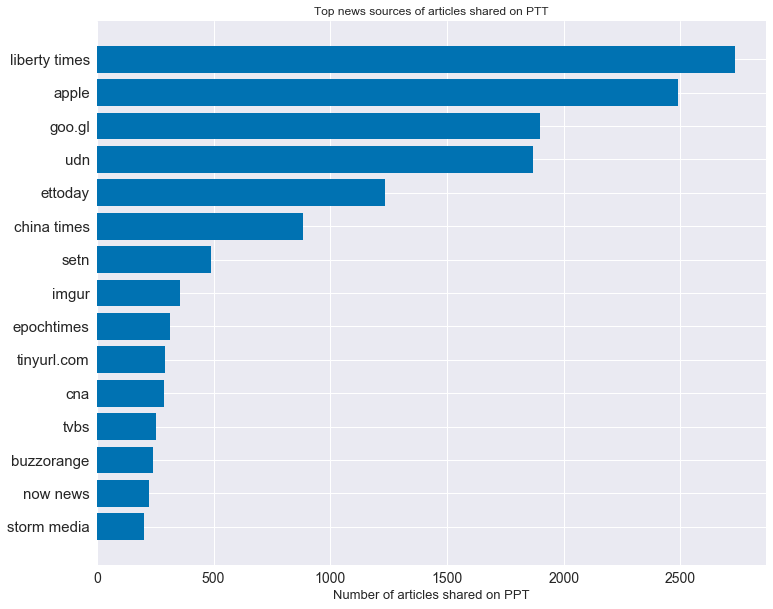

In [8]:
%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.figure(figsize=(12, 10))
plt.title("Top news sources of articles shared on PTT")
plt.barh(np.arange(0,15,1), df["source"].value_counts().tolist()[:15])
ax = plt.gca()
_ = ax.invert_yaxis()
_ = ax.set_yticklabels(df["source"].value_counts().index[:15], fontsize='15')
_ = ax.set_xticklabels(np.arange(0,6000,500), fontsize='14')
_ = ax.set_yticks(np.arange(0,15,1))
ax.set_xlabel('Number of articles shared on PPT', fontsize='13')


---
### Plot upvotes vs forwards

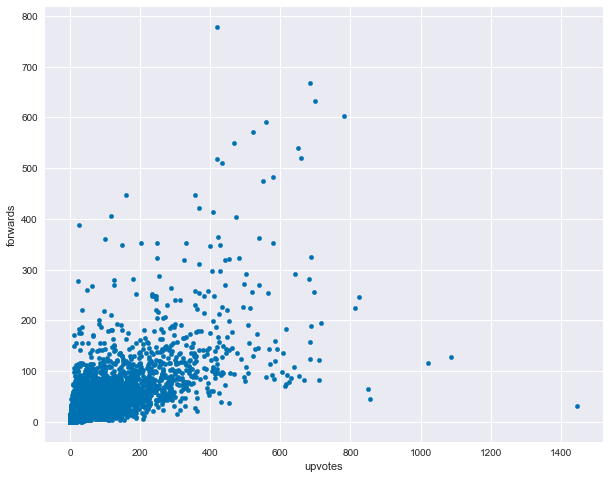

In [10]:
df.plot.scatter('upvotes','forwards',figsize=(10, 8))

---
### Filtering by top writers

In [12]:
topauthors = df["author"].value_counts().index.values
df_top10authors = df[df["author"].isin(topauthors[:10])]
df_top10authors["id_author"] = df_top10authors["author"].apply(lambda x: np.where(topauthors[:10] == x)[0][0] + 1)
df_top10authors.shape

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(847, 10)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
smat = TfidfVectorizer().fit_transform(df_top10authors["tokens"].values)
smat.shape

(847, 3948)

### Perform tSNE on truncated data to save time

In [18]:
from sklearn.decomposition import TruncatedSVD

smat_50 = TruncatedSVD(n_components = 50, random_state = 0).fit_transform(smat)
smat_50.shape

(847, 50)

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=2,
    random_state=101,
    #perplexity = 5,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
).fit_transform(smat_50)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 847 / 847
[t-SNE] Mean sigma: 0.054361
[t-SNE] Iteration 25: error = 1.0675659, gradient norm = 0.0162857
[t-SNE] Iteration 50: error = 1.0498644, gradient norm = 0.0148060
[t-SNE] Iteration 75: error = 0.6762921, gradient norm = 0.0076999
[t-SNE] Iteration 100: error = 0.6620607, gradient norm = 0.0083872
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.662061
[t-SNE] Iteration 125: error = 0.5821584, gradient norm = 0.0038843
[t-SNE] Iteration 150: error = 0.5823601, gradient norm = 0.0052152
[t-SNE] Iteration 175: error = 0.5963241, gradient norm = 0.0053520
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.662061


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [21]:
trace1 = go.Scatter(
    x=tsne[:,0],
    y=tsne[:,1],
    #z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = df_top10authors["id_author"].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'author'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='test')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='NewsScatter2D')

---
### Like Analysis

In [27]:
df["upvotes"] = df["upvotes"].fillna(0).astype(int)
df["downvotes"] = df["downvotes"].fillna(0).astype(int)
df.dtypes

author           object
datetime         object
upvotes           int64
downvotes         int64
forwards          int64
source           object
headline         object
original_link    object
tokens           object
dtype: object

---
### Liked = 1 if number of upvotes is at least 60% of total votes

In [28]:
a = df["upvotes"]/(df["upvotes"]+df["downvotes"])
df["liked"] = a.apply(lambda x: int(x > 0.6))

---
### Let's take a look at authors whose posts are disliked

In [29]:
badauthors = df['author'][df["liked"]==0].value_counts()
badauthors = badauthors[badauthors>20]

---
### Analysis of why some news articles are disliked

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
vectorizer = TfidfVectorizer()
smat_disliked = vectorizer.fit_transform(df[(df["author"].isin(badauthors.index)) & (df["liked"] == 0)]["tokens"].values)
features = vectorizer.get_feature_names()
smat_disliked.shape

(2584, 8183)

---
### Let's take a look at keywords in news articles that are disliked

In [32]:
indices = np.argsort(vectorizer.idf_)[::-1]
[features[i] for i in indices[:100]]

['龜速',
 '性大勝',
 '性玩具',
 '性病',
 '性質',
 '性連上',
 '怪東',
 '怪民進',
 '怪物',
 '怪當',
 '怪西',
 '恐使',
 '恐免',
 '恐全盤',
 '恐共',
 '恐嚇',
 '恐孫症',
 '恐影響',
 '恐得',
 '恐怕',
 '恐懼',
 '恐成',
 '恩人',
 '恩情',
 '悄悄',
 '性愛權',
 '性別',
 '悲傷',
 '急載',
 '忠信',
 '快刀',
 '快掛',
 '快樂',
 '快百萬',
 '快艇',
 '快訊',
 '快評',
 '快遞',
 '忽視',
 '怎走',
 '怒喊告',
 '怒噴',
 '怒槓',
 '思思',
 '思純',
 '思考',
 '怡潔批',
 '急凍',
 '急切',
 '急徵',
 '急拉',
 '急診',
 '患者',
 '悲劇',
 '志祥力',
 '愚人',
 '愛人',
 '愛兒',
 '愛嗎',
 '愛國',
 '愛國行',
 '愛女護爸',
 '愛心',
 '愛愛',
 '愛有',
 '愛滋賊',
 '愛玩女',
 '愛珍',
 '愛的',
 '愛盧',
 '愛罵',
 '愛美',
 '愛能',
 '愛腦公',
 '愛計',
 '愛講話',
 '愛車',
 '感人',
 '感到',
 '愛中國',
 '意志',
 '悲哀',
 '愈紀念',
 '悲歌',
 '情信',
 '情書',
 '情深',
 '情趣',
 '情願',
 '惡作劇',
 '惡少',
 '惡性',
 '惡意',
 '惡業者',
 '惡行',
 '惡閨密',
 '惡靈',
 '惡鬥',
 '想不出',
 '想像']

---

In [42]:
df = pd.read_csv("data/news.csv")

In [43]:
def getSourceFromLink(link):
    if pd.isnull(link):
        return ''
    source = ''
    if r'udn.com' in link:
        source = 'udn'
    elif r'epochtimes' in link or r'大紀元' in link:
        source = 'epochtimes'
    elif r'imgur' in link:
        source = 'imgur'
    elif r'youtu' in link:
        source = 'youtube'
    elif r'cna' in link or r'中央' in link:
        source = 'cna'
    elif r'hinet' in link:
        source = 'hinet'
    elif r'cnyes' in link:
        source = 'cnyes'
    elif r'鉅亨' in link:
        source = 'cnyes'
    elif r'公視' in link or r'pts' in link:
        source = 'pts'
    elif r'peoplenews' in link:
        source = 'peoplenews'
    elif r'ithome' in link:
        source = 'ithome'
    elif r'cdnews' in link:
        source = 'cdnews'
    elif r'rti' in link:
        source = 'rti'
    elif r'ctee' in link:
        source = 'ctee'
    elif r'nextmag' in link:
        source = 'nextmag'
    elif r'lens' in link:
        source = 'thenewslens'
    elif r'initium' in link:
        source = 'theinitium'
    elif r'apple' in link:
        source = 'apple'
    elif r'bbc.' in link:
        source = 'bbc'
    elif r'buzzfeed' in link:
        source = 'buzzfeed'
    elif r'buzzorange.com' in link:
        source = 'buzzorange'
    elif r'ettoday' in link:
        source = 'ettoday'
    elif r'ntdtv.com' in link:
        source = 'ntdtv'
    elif r'ltn.com' in link:
        source = 'liberty times'
    elif r'technews' in link or r'科技新報' in link:
        source = 'technews'
    elif r'tvbs.com' in link:
        source = 'tvbs'
    elif r'wsj.net' in link or r'wsj.com' in link:
        source = 'wsj'
    elif r'yahoo' in link:
        source = 'yahoo'
    elif r'yam.com' in link:
        source = 'yam'
    elif r'setn.com' in link:
        source = '三立'
    elif r'worldjournal.com' in link:
        source = 'world journal'
    elif r'upmedia.mg' in link:
        source = 'up media'
    elif r'ctitv.com' in link:
        source = 'ctitv'
    elif r'bcc.com' in link:
        source = 'bcc'
    elif r'chinatimes.com' in link or r'中國時報' in link:
        source = 'china times'
    elif r'nextmedia' in link:
        source = 'next media'
    elif r'ftv.com' in link:
        source = 'formosa tv'
    elif r'cts.com' in link:
        source = 'cts'
    elif r'mirrormedia.' in link:
        source = 'mirror media'
    elif r'storm.mg' in link:
        source = 'storm media'
    elif r'nownews.' in link:
        source = 'now news'
    elif r'pchome.' in link:
        source = 'pchome'
    elif r'newtalk.tw' in link:
        source = 'newtalk'
    else:
        a = link.split('//')
        if len(a) > 1:
            source = link.split('//')[1].split('/')[0]
    return source

In [47]:
df.columns.values

array(["'author'", " 'datetime'", " 'upvotes'", " 'downvotes'",
       " 'forwards'", " 'source'", " 'headline'", " 'original_link'+'"], dtype=object)

In [45]:
for i, row in df.iterrows():
    if pd.isnull(row['source']):
        df.set_value(index=i, col='source', value=getSourceFromLink(row['original_link']))

KeyError: 'source'

In [41]:
(','.join(df.columns.values))

'hitosh723 (楓葉狂刀),Thu Jun  1 10:25:28 2017,2,0,5,liberty times,[新聞] 今北高溫南有雨 吳德榮：明後天全台防雷,Unnamed: 7'